In [0]:
try: import nlp
except ImportError: 
  %pip install -q nlp
  exit() # In Colab, to use the newer installed pyarrow, you need to restart your session for first use
try: import fastai2
except ImportError: 
  !git clone https://github.com/fastai/fastai2
  %cd fastai2
  %pip install -qe ".[dev]"
  %cd .. 
try: import transformers
except ImportError: 
  %pip install -q transformers
try: import _utils
except ImportError: 
  !git clone https://github.com/richardyy1188/Pretrain-MLM-and-finetune-on-GLUE-with-fastai.git

In [0]:
%cd Pretrain-MLM-and-finetune-on-GLUE-with-fastai

from pathlib import Path
from functools import partial
from IPython.core.debugger import set_trace as bk
import pandas as pd
from torch import nn
import nlp
from transformers import ElectraModel, ElectraTokenizer, ElectraTokenizerFast
from fastai2.text.all import *
from _utils.would_like_to_pr import *
from _utils.hf_integration import *

[Errno 2] No such file or directory: 'Pretrain-MLM-and-finetune-on-GLUE-with-fastai'
/content/Pretrain-MLM-and-finetune-on-GLUE-with-fastai


In [0]:
""" tokenizer and fast tokenizer
We use normal tokenizer to get vocab, use fast tokenizer to convert tokens to ids.
Because we can't get vocab from fast tokenizer and fast tokenizer is faster,
and they share the same token-id mapping.
"""
hf_tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
hf_fast_tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-small-discriminator")
base_model = ElectraModel.from_pretrained('google/electra-small-discriminator')

# 1. Prepare data

## 1.1 Download

**Download, Preprocess, and Cache**

In Colab, it takes you 20+ minutes for the first time, and seconds for subsequent calls. 

It will cost serveral minutes if you reset runtime even load the cache, but it's not true when you just restart the runtime. So I guess they may keep someth

In [0]:
# create a 'glue' folder under it, and all cache files will be under 'glue'
cache_dir=Path('/content/drive/My Drive/datasets')
cache_dir.mkdir(parents=True, exist_ok=True) # create recursively if not exist

def textcols(dataset):
  "Infer text cols of different GLUE datasets in huggingface/nlp"
  column_names = dataset.column_names
  if 'question' in column_names: return ['question', 'sentence']
  elif 'sentence1' in column_names: return ['sentence1', 'sentence2']
  elif 'question1' in column_names: return ['question1','question2']
  elif 'premise' in column_names: return ['premise','hypothesis']
  elif 'sentence' in column_names: return ['sentence']

"""
quote from transformers tutorial of fastai (http://dev.fast.ai/tutorial.transformers)
we don't use the tokenizer.encode method since it does some additional preprocessing for the model after tokenizing and numericalizing (the aprt throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
"""
def tokenize_sents(example, cols):
  if len(cols)==1:
    example['input_ids'] = hf_fast_tokenizer.convert_tokens_to_ids(hf_fast_tokenizer.tokenize(f"[CLS] {example[cols[0]]} [SEP]"))
  elif len(cols)==2:
    example['input_ids'] = concat(hf_fast_tokenizer.convert_tokens_to_ids(hf_fast_tokenizer.tokenize(f'[CLS] {example[cols[0]]} [SEP]')),
                                  hf_fast_tokenizer.convert_tokens_to_ids(hf_fast_tokenizer.tokenize(f'{example[cols[1]]} [SEP]')))
  else: raise ValueError()
  return example

glue_dsets = {}
for glue_task in ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'qnli', 'rte', 'wnli', 'ax']:
  task = nlp.load_dataset('glue', glue_task, cache_dir=cache_dir)
  glue_dsets[glue_task] = {}
  print(f'loading processed datasets of {glue_task} ...')
  for split in task.keys():
    raw_dataset = task[split]
    cache_file = Path(raw_dataset.cache_files[0]['filename']).parent / f'tokenized_{split}.arrow'
    if cache_file.exists():dataset = nlp.Dataset.from_file(str(cache_file))
    else: dataset = raw_dataset.map(partial(tokenize_sents, cols=textcols(raw_dataset)),
                                    cache_file_name=str(cache_file))
    glue_dsets[glue_task][split] = dataset 


loading processed datasets of cola ...
loading processed datasets of sst2 ...
loading processed datasets of mrpc ...
loading processed datasets of qqp ...
loading processed datasets of stsb ...
loading processed datasets of mnli ...
loading processed datasets of qnli ...
loading processed datasets of rte ...
loading processed datasets of wnli ...
loading processed datasets of ax ...


## 1.2 hf/hlp datasets -> fastai dataloaders

In [0]:
# I don't know how to let `Learner` validate two validation sets every epochs, so I just merged `mnli validation mismatched` and `mnli validation matched`.
glue_dsets['mnli']['validation'] = HF_MergedDataset(glue_dsets['mnli']['validation_matched'], glue_dsets['mnli']['validation_mismatched'])

In [0]:
def text_decode_fc(x, pretty=True):
  if pretty:
    return hf_fast_tokenizer.decode([idx for idx in x if idx != hf_fast_tokenizer.pad_token_id])
  else:
    tokens = hf_fast_tokenizer.convert_ids_to_tokens(x)
    return ' '.join(tokens)

@delegates(FilteredBase.dataloaders)
def get_glue_dls(task_name, **kwargs):
  assert task_name in ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'qnli', 'rte', 'wnli', 'ax']
  splits = ['train','validation']+(['test'] if task_name != 'mnli' else ['test_matched', 'test_mismatched'])
  if task_name == 'ax': splits = ['test']
  arrow_dsets = [glue_dsets[task_name][s] for s in splits ]
  show_pretty = kwargs.pop('show_pretty', True) 
  dsets = HF_Datasets(datasets=arrow_dsets, 
                      cols=['input_ids', 'label'],
                      encode_types=[TensorText, noop],
                      decode_funcs=[partial(text_decode_fc,pretty=show_pretty),noop],
                      decode_types=[TitledStr, lambda x: Category(x.item())])
  dl_cache_files = [Path(dset.cache_files[0]['filename']).parent/f'dl_{s}.pth' for dset, s in zip(dsets,splits)]
  if all([ p.exists() for p in dl_cache_files]):
    device = kwargs.pop('device', default_device())
    dl_s = [TextDataloader.from_cache(f, dsets[i], bs=32, **kwargs) for i, f in enumerate(dl_cache_files)]  
    dls = DataLoaders(*dl_s, device=device)
  else:
    dls = dsets.dataloaders(before_batch=partial(pad_input_chunk,pad_first=False,pad_idx=hf_fast_tokenizer.pad_token_id,),
                             dl_type=partial(TextDataloader, sort_by_len=False),
                            bs=32,
                             **kwargs)
    for dl, cache_f in zip(dls,dl_cache_files): dl.cache(cache_f)
  return dls

## 1.3 Get dataloaders fror each dataset

**[CoLA](https://nyu-mll.github.io/CoLA/)** (*The Corpus of Linguistic Acceptability*):


Check whether a sentence is linguistically acceptable. 

(0: unacceptable, 1: acceptable) 

In [0]:
cola_dls = get_glue_dls('cola', show_bar=False)
print(f"Dataset size (train/valid/test): {len(cola_dls[0].dataset)}/{len(cola_dls[1].dataset)}/{len(cola_dls[2].dataset)}")
cola_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 8551/1043/1063


,text,category
0,"[CLS] our friends won't buy this analysis, let alone the next one we propose. [SEP]",1
1,[CLS] one more pseudo generalization and i'm giving up. [SEP],1


**Note**: for the readibility, we won't show pad and result of sentencepiece ('##...') here, which are the actual results in a batch.

In [0]:
get_glue_dls('cola', show_bar=False, show_pretty=False).show_batch(max_n=2)

,text,category
0,"[CLS] our friends won ' t buy this analysis , let alone the next one we propose . [SEP]",1
1,[CLS] one more pseudo general ##ization and i ' m giving up . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD],1


**[SST-2](https://nlp.stanford.edu/sentiment/index.html)** (*The Stanford Sentiment Treebank*): 

Identify the sentiment of a work/phrase/sentence. 

(1: positvie, 0: negative)

In [0]:
sst2_dls = get_glue_dls('sst2')
print(f"Dataset size (train/valid/test): {len(sst2_dls[0].dataset)}/{len(sst2_dls[1].dataset)}/{len(sst2_dls[2].dataset)}")
sst2_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 67349/872/1821


,text,category
0,[CLS] hide new secretions from the parental units [SEP],0
1,"[CLS] contains no wit, only labored gags [SEP]",0


**[MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398)** (*Microsoft Research Paraphrase Corpus*): 

Whether each pair captures a paraphrase/semantic equivalence relationship. 

(1: yes, 0: no)

In [0]:
mrpc_dls = get_glue_dls('mrpc',show_bar=False)
print(f"Dataset size (train/valid/test): {len(sst2_dls.train_ds)}/{len(sst2_dls.valid_ds)}/{len(sst2_dls[2])}")
mrpc_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 67349/872/57


,text,category
0,"[CLS] amrozi accused his brother, whom he called "" the witness "", of deliberately distorting his evidence. [SEP] referring to him as only "" the witness "", amrozi accused his brother of deliberately distorting his evidence. [SEP]",1
1,[CLS] yucaipa owned dominick's before selling the chain to safeway in 1998 for $ 2. 5 billion. [SEP] yucaipa bought dominick's in 1995 for $ 693 million and sold it to safeway for $ 1. 8 billion in 1998. [SEP],0


**[STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark)** (*Semantic Textual Similarity Benchmark*):

Score the similarity of meanings of two sentences. The only regression task in GLUE 

(0.0 ~ 5.0)

In [0]:
stsb_dls = get_glue_dls('stsb',show_bar=False)
print(f"Dataset size (train/valid/test): {len(stsb_dls.train_ds)}/{len(stsb_dls.valid_ds)}/{len(stsb_dls[2])}")
stsb_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 5749/1500/44


,text,category
0,[CLS] a plane is taking off. [SEP] an air plane is taking off. [SEP],5.0
1,[CLS] a man is playing a large flute. [SEP] a man is playing a flute. [SEP],3.799999952316284


**[QQP](https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs)** (*Quora Question Pairs*)

Check whether two questions are duplicated. 

(0: no, 1: duplicated)

In [0]:
qqp_dls = get_glue_dls('qqp')
print(f"Dataset size (train/valid/test): {len(qqp_dls.train_ds)}/{len(qqp_dls.valid_ds)}/{len(qqp_dls[2])}")
qqp_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 363849/40430/12218


,text,category
0,[CLS] how is the life of a math student? could you describe your own experiences? [SEP] which level of prepration is enough for the exam jlpt5? [SEP],0
1,[CLS] how do i control my horny emotions? [SEP] how do you control your horniness? [SEP],1


**[MNLI](https://cims.nyu.edu/~sbowman/multinli/)** (*The Multi-Genre NLI Corpus*)

Whether the premise (sentence 1) entails the hypothesis (sentence 2) (entailment), contradicts the hypothesis (contradiction), or neither (neutral) 

(0: entailment, 1: neutral, 2: contradiction)

In [0]:
mnli_dls = get_glue_dls('mnli')
print(f"Dataset size (train/valid/test_matched/test_mismatched): {len(mnli_dls[0].dataset)}/{len(mnli_dls[1].dataset)}/{len(mnli_dls[2].dataset)}/{len(mnli_dls[3].dataset)}")
mnli_dls.show_batch(max_n=2)

Dataset size (train/valid/test_matched/test_mismatched): 392702/19647/9796/9847


,text,category
0,[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP],1
1,[CLS] you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the braves decide to call to recall a guy from triple a then a double a guy goes up to replace him and a single a guy goes up to replace him [SEP] you lose the things to the following level if the people recall. [SEP],0


**QNLI** (*The Stanford Question Answering Dataset*):

The task is to determine whether the context sentence (sentence 2) contains the answer to the question (sentence 1).

(0: entailment, 1: not_entailment)

In [0]:
qnli_dls = get_glue_dls('qnli')
print(f"Dataset size (train/valid/test): {len(qnli_dls[0].dataset)}/{len(qnli_dls[1].dataset)}/{len(qnli_dls[2].dataset)}")
qnli_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 104743/5463/5463


,text,category
0,"[CLS] when did the third digimon series begin? [SEP] unlike the two seasons before it and most of the seasons that followed, digimon tamers takes a darker and more realistic approach to its story featuring digimon who don't reincarnate after their deaths and more complex character development in the original japanese. [SEP]",1
1,"[CLS] which missile batteries often have individual launchers several kilometres from one another? [SEP] when manpads is operated by specialists, batteries may have several dozen teams deploying separately in small sections ; self - propelled air defence guns may deploy in pairs. [SEP]",1


**[RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment)** (*Recognizing_Textual_Entailment*):

Whether hypothesis (sentence 2) is entailed (can be inferred) from the premise (sentence 1).

(0: entailment, 1: not_entailment)

In [0]:
rte_dls = get_glue_dls('rte', show_bar=False)
print(f"Dataset size (train/valid/test): {len(rte_dls[0].dataset)}/{len(rte_dls[1].dataset)}/{len(rte_dls[2].dataset)}")
rte_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 2490/277/3000


,text,category
0,[CLS] no weapons of mass destruction found in iraq yet. [SEP] weapons of mass destruction found in iraq. [SEP],1
1,"[CLS] a place of sorrow, after pope john paul ii died, became a place of celebration, as roman catholic faithful gathered in downtown chicago to mark the installation of new pope benedict xvi. [SEP] pope benedict xvi is the new leader of the roman catholic church. [SEP]",0


**[WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html)** (*The Winograd Schema Challenge*)

Check whether sentence 2 (which is rephrased sentence of sentence 1) correctly solve the pronoun in sentence 1.

(0: wrong, 1: correct)

In [0]:
wnli_dls = get_glue_dls('wnli', show_bar=False)
print(f"Dataset size (train/valid/test): {len(wnli_dls[0].dataset)}/{len(wnli_dls[1].dataset)}/{len(wnli_dls[2].dataset)}")
wnli_dls.show_batch(max_n=2)

Dataset size (train/valid/test): 635/71/146


,text,category
0,"[CLS] i stuck a pin through a carrot. when i pulled the pin out, it had a hole. [SEP] the carrot had a hole. [SEP]",1
1,[CLS] john couldn't see the stage with billy in front of him because he is so short. [SEP] john is so short. [SEP],1


**[AX](https://gluebenchmark.com/diagnostics)** (*GLUE Diagnostic Dataset*):

Whether the premise (sentence 1) entails the hypothesis (sentence 2) (entailment), contradicts the hypothesis (contradiction), or neither (neutral) 

Test set only.

The label is all -1, because this is a test dataset and the answers is kept by GLUE benchmark and not provided. The categories are the same as MNLI (entailment, neutral, contradiction)

In [0]:
ax_dls = get_glue_dls('ax')
print(f"Dataset size (test): {len(ax_dls[0].dataset)}")
ax_dls.show_batch(max_n=2)

Dataset size (test): 1104


,text,category
0,[CLS] the cat sat on the mat. [SEP] the cat did not sit on the mat. [SEP],-1
1,[CLS] the cat did not sit on the mat. [SEP] the cat sat on the mat. [SEP],-1


In [0]:
glue_dls = {}
for task_name in ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'qnli', 'rte', 'wnli', 'ax']:
  dls = eval(f"{task_name}_dls")
  if task_name != 'ax':
    dls[0].desc_sort(); dls[1].desc_sort(); # sort by len to reduce pad, but not for test_dl which keep the order of sample to let us add the dataset idx conveniently later 
  glue_dls[task_name] = dls
glue_dls['ax'][0].shuffle = False # fastai see 0th dl as train_dl which is default shuffled

# 2. Finetuning model

* ELECTRA use CLS encodings as pooled result to predict the sentence. (see [here](https://github.com/google-research/electra/blob/79111328070e491b287c307906701ebc61091eb2/model/modeling.py#L254) of its official repository)

* Note that we should use different prediction head for different tasks.

In [0]:
class SentencePredictHead(nn.Module):
  "The way that Electra and Bert do for sentence prediction task"
  def __init__(self, hidden_size, targ_voc_size):
    super().__init__()
    self.linear = nn.Linear(hidden_size, targ_voc_size)
    self.dropout = nn.Dropout(0.1)
  def forward(self, x):
    "x: (batch size, sequence length, hidden_size)"
    return self.linear(self.dropout(x[:,0])) # project the first token (a special token)'s hidden encoding

`SentencePredictHead`
* change `targ_voc_size` for diffrent task
* change `256` for your model's hidden size

In [0]:
single_task_model = nn.Sequential(HF_ModelWrapper(base_model, pad_id=hf_tokenizer.pad_token_id, sep_id=hf_tokenizer.sep_token_id), # specify spe_id and wrapper will create and pass token_type_ids of sentece A/B for you
                                  SentencePredictHead(256, targ_voc_size=2)) # <- change targ_voc_size according to the task
inp_tensor = torch.tensor(hf_tokenizer.encode('I am the sentence A','I am the sentence B'))[None,:] 
print(f'input shape: {inp_tensor.shape} (batch size, sequence length)')
with torch.no_grad(): out_tensor = single_task_model(inp_tensor)
print(f'output shape: {out_tensor.shape} (batch_size, target vocab size)')
print(f'The output is the raw score-like thing for each label')
print(out_tensor)

input shape: torch.Size([1, 13]) (batch size, sequence length)
output shape: torch.Size([1, 2]) (batch_size, target vocab size)
The output is the raw score-like thing for each label
tensor([[ 0.1295, -0.3478]])


# 3. Single Task Finetuning

## 3.1 Discriminative learning rate

In [0]:
# Names come from, for nm in model.named_modules(): print(nm[0])
def hf_electra_param_splitter(model, num_hidden_layers, outlayer_name):
  names = ['model.embeddings', *[f'model.encoder.layer.{i}' for i in range(num_hidden_layers)], outlayer_name]
  def endswith_any(n,ns): return any([ n.endswith(suffix) for suffix in ns])
  groups = [ list(mod.parameters()) for name, mod in model.named_modules() if endswith_any(name, names) ]
  assert len(groups) == len(names)
  return groups

def get_layer_lrs(lr, decay_rate_of_depth, num_hidden_layers):
  # I think input layer as bottom and output layer as top, which make 'depth' mean different from the one of official repo 
  return [ lr * (decay_rate_of_depth ** depth) for depth in reversed(range(num_hidden_layers+2))]


## 3.2 Learning rate schedule

In [0]:
def linear_warmup_and_decay(pct_now, lr_max, end_lr, decay_power, warmup_pct, total_steps):
  """
  end_lr: the end learning rate for linear decay
  warmup_pct: percentage of training steps to for linear increase
  pct_now: percentage of traning steps we have gone through, notice pct_now=0.0 when calculating lr for first batch.
  """
  """
  pct updated after_batch, but global_step (in tf) seems to update before optimizer step,
  so pct is actually (global_step -1)/total_steps 
  """
  fixed_pct_now = pct_now + 1/total_steps
  """
  According to source code of the official repository, it seems they merged two lr schedule (warmup and linear decay)
  sequentially, instead of split training into two phases for each, this might because they think when in the early
  phase of training, pct is low, and thus the decaying formula makes little difference to lr.
  """
  decayed_lr = (lr_max-end_lr) * (1-fixed_pct_now)**decay_power + end_lr # https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/polynomial_decay
  warmed_lr = decayed_lr * min(1.0, fixed_pct_now / warmup_pct) # https://github.com/google-research/electra/blob/81f7e5fc98b0ad8bfd20b641aa8bc9e6ac00c8eb/model/optimization.py#L44
  return warmed_lr


## 3.3 finetune

In [0]:
num_epochs = 3
dls = glue_dls['mrpc']

layer_lrs = get_layer_lrs(lr=3e-4,
                          decay_rate_of_depth=0.8,
                          num_hidden_layers=base_model.config.num_hidden_layers)

lr_shedule = ParamScheduler({'lr': partial(linear_warmup_and_decay,
                                            lr_max=np.array(layer_lrs),
                                            end_lr=0.0,
                                            decay_power=1,
                                            warmup_pct=0.1,
                                            total_steps=num_epochs*(len(dls.train)))})

single_task_learn = Learner(dls, single_task_model,
                            # flatten only if needed, here in fact we don't need
                            # if regression task (STS-B), use MSELossFlat() instead
                            loss_func=CrossEntropyLossFlat(), 
                            opt_func=partial(Adam, eps=1e-6,),
                            metrics=[F1Score(), Accuracy()],
                            splitter=partial(hf_electra_param_splitter, 
                                             num_hidden_layers=base_model.config.num_hidden_layers, 
                                             outlayer_name='1'),
                            #lr=layer_lrs,
                            )#.to_fp16()

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.515391,0.372465,0.878403,0.835784,00:09
1,0.348412,0.444597,0.890675,0.833333,00:09
2,0.230610,0.312393,0.903678,0.865196,00:09


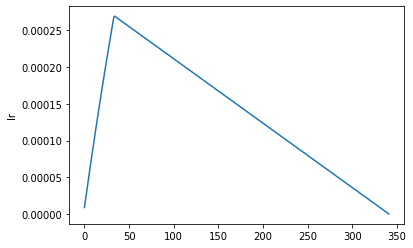

In [54]:
single_task_learn.fit(n_epoch=num_epochs,
                      cbs=[lr_shedule])
single_task_learn.recorder.plot_sched() # print last lr of last paramters groups (output layer)

## 3.3 Predict the test set

In [0]:
test_pred_dir = cache_dir/'glue'/'test'
test_pred_dir.mkdir(exist_ok=True)
preds = single_task_learn.get_preds(dl=glue_dls['mrpc'][2], with_decoded=True)
preds = preds[-1] # preds -> (predictions logits, targets, decoded prediction)
cols = ['idx', *textcols(glue_dsets['mrpc']['test'])]
test_df = pd.DataFrame( data={**{col:glue_dsets['mrpc']['test'][col] for col in cols}, 
                             'prediction': preds.tolist()} )
test_df.to_csv( test_pred_dir/'MRPC.tsv', sep='\t' )
test_df.head(n=3)